In [1]:
# ============================================================================
# CELL 1: IMPORTS AND GLOBAL PARAMETERS
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from collections import defaultdict

# Set the parameters for the Lorenz system.
sigma = 10.0
rho = 28.0
beta = 8.0/3.0

# Set the default parameters for the reservoir computer.
N = 10            # Number of reservoir neurons.
P = 0.05            # Connection probability.
rho_res = 0.6       # Spectral radius.
sigma_in = 0.2      # Input scaling.
gamma = 10.0        # Leaking rate.
beta_ridge = 1e-4   # Regularization for ridge regression.

# Set the time steps for the simulation.
dt = 0.01           # Integration time step.
t_listen = 100.0    # Washout time.
t_train = 100.0     # Training time.
t_predict = 300.0   # Prediction time.

# Set the initial conditions.
lorenz_ic = np.array([1.0, 1.0, 1.0])
# Set a random seed for reproducibility.
random_seed = 42

In [2]:
# ============================================================================
# CELL 2: CORE MATHEMATICAL AND SYSTEM FUNCTIONS
# ============================================================================

def lorenz_system(u, sigma, rho, beta):
    """Defined the Lorenz system equations."""
    x, y, z = u
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])

def reservoir_dynamics(r, u, M, W_in, gamma, sigma_in):
    """Defined the reservoir's state update equation."""
    internal_state = M @ r + sigma_in * W_in @ u
    dr_dt = gamma * (-r + np.tanh(internal_state))
    return dr_dt

def rk4_integrator(dynamics_func, state, dt, *args):
    """Implemented a 4th-order Runge-Kutta integrator."""
    k1 = dynamics_func(state, *args)
    k2 = dynamics_func(state + 0.5 * dt * k1, *args)
    k3 = dynamics_func(state + 0.5 * dt * k2, *args)
    k4 = dynamics_func(state + dt * k3, *args)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state

def state_augmentation(r):
    """Augmented the reservoir state with squared terms for a non-linear readout."""
    return np.concatenate([r, r**2])

def ridge_regression(X, Y, beta_ridge):
    """Implemented ridge regression to find the output weights."""
    XXT = X @ X.T
    identity_matrix = np.eye(XXT.shape[0])
    reg_matrix = XXT + beta_ridge * identity_matrix
    W_out = Y @ X.T @ np.linalg.inv(reg_matrix)
    return W_out

def generate_reservoir_matrices(N, P, rho_res, seed=None):
    """Created the reservoir's internal and input matrices."""
    if seed is not None:
        np.random.seed(seed)

    connections = np.random.rand(N, N) < P
    M = np.random.uniform(-1, 1, (N, N)) * connections

    eigenvals = np.linalg.eigvals(M)
    current_rho = np.max(np.abs(eigenvals))
    if current_rho > 0:
        M = M * (rho_res / current_rho)

    W_in = np.zeros((N, 3))
    for i in range(N):
        col_idx = np.random.randint(0, 3)
        W_in[i, col_idx] = np.random.uniform(-1, 1)

    return M, W_in



In [3]:
def generate_lorenz_data(total_time, dt, initial_condition):
    """Generated the target Lorenz system data."""
    print("Generating Lorenz attractor data...")
    num_steps = int(total_time / dt)
    u_series = np.zeros((3, num_steps))
    u_current = initial_condition.copy()
    for i in range(num_steps):
        u_series[:, i] = u_current
        u_current = rk4_integrator(lorenz_system, u_current, dt, sigma, rho, beta)
    print(f"Generated {num_steps} data points.")
    return u_series, np.arange(num_steps) * dt

def listening_phase(u_series, M, W_in, t_listen, dt):
    """Ran the reservoir washout phase."""
    print("\nPHASE 1: LISTENING/WASHOUT")
    N = M.shape[0]
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N)
    for i in range(num_listen_steps):
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt, u_series[:, i], M, W_in, gamma, sigma_in)
    print("Listening phase completed.")
    return r_current

def training_phase(u_series, r_initial, M, W_in, t_listen, t_train, dt):
    """Ran the training phase to get the output weights."""
    print("\nPHASE 2: TRAINING")
    N = M.shape[0]
    num_listen_steps = int(t_listen / dt)
    num_train_steps = int(t_train / dt)
    X = np.zeros((2 * N, num_train_steps))
    Y = u_series[:, num_listen_steps : num_listen_steps + num_train_steps]

    r_current = r_initial.copy()
    for i in range(num_train_steps):
        X[:, i] = state_augmentation(r_current)
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt, Y[:, i], M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)
    print("Training completed.")
    return W_out, r_current

def prediction_phase(r_initial, M, W_in, W_out, t_predict, dt):
    """Ran the autonomous prediction phase."""
    print("\nPHASE 3: AUTONOMOUS PREDICTION")
    N = M.shape[0]
    num_predict_steps = int(t_predict / dt)
    u_pred = np.zeros((3, num_predict_steps))

    r_current = r_initial.copy()
    for i in range(num_predict_steps):
        q_current = state_augmentation(r_current)
        u_hat = W_out @ q_current
        u_pred[:, i] = u_hat
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt, u_hat, M, W_in, gamma, sigma_in)
    print("Prediction completed.")
    return u_pred, r_current

In [4]:
def analyze_reconstruction(u_true, u_pred, t_predict, dt):
    """
    Analyze the quality of Lorenz attractor reconstruction.
    
    Args:
        u_true: True Lorenz trajectory
        u_pred: Predicted Lorenz trajectory  
        t_predict: Prediction time duration
        dt: Time step
    
    Returns:
        analysis_results: Dictionary with error metrics
    """
    print("\n" + "="*60)
    print("RECONSTRUCTION ANALYSIS")
    print("="*60)
    
    num_predict_steps = int(t_predict / dt)
    
    # Calculate prediction error
    pred_error = np.mean(np.linalg.norm(u_true[:, :num_predict_steps] - u_pred, axis=0))
    
    # Short-term prediction accuracy (first 50 time units)
    short_steps = min(int(50 / dt), num_predict_steps)
    short_error = np.mean(np.linalg.norm(u_true[:, :short_steps] - u_pred[:, :short_steps], axis=0))
    
    print(f"Overall prediction RMSE: {pred_error:.6f}")
    print(f"Short-term prediction RMSE (first {short_steps*dt:.1f}s): {short_error:.6f}")
    
    # Assess reconstruction quality
    if short_error < 1.0:
        print("\n✓ RECONSTRUCTION SUCCESSFUL!")
        print("  Reservoir has successfully learned the Lorenz attractor dynamics")
    else:
        print("\n✗ Reconstruction needs improvement")
        print("  Consider adjusting reservoir parameters")
    
    return {
        'overall_error': pred_error,
        'short_term_error': short_error,
        'success': short_error < 1.0
    }
    
def visualize_results(u_true, u_pred, t_listen, t_train, t_predict, dt):
    """
    Create comprehensive visualization of reconstruction results.
    
    Args:
        u_true: True Lorenz trajectory
        u_pred: Predicted Lorenz trajectory
        t_listen, t_train, t_predict: Phase durations
        dt: Time step
    """
    print("\nGenerating visualization...")
    
    num_listen_steps = int(t_listen / dt)
    num_train_steps = int(t_train / dt)
    num_predict_steps = int(t_predict / dt)
    
    # Training phase data
    train_start = num_listen_steps
    train_end = num_listen_steps + num_train_steps
    
    # Create visualization
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Training Phase - 3D Attractor
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.plot(u_true[0, train_start:train_end], 
             u_true[1, train_start:train_end], 
             u_true[2, train_start:train_end], 
             'red', alpha=0.8, linewidth=1.5, label='True Lorenz')
    
    ax1.set_title('Training Phase: True Lorenz Attractor', fontsize=12)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()
    
    # Plot 2: Prediction Phase - 3D Reconstruction
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
             'darkblue', alpha=0.8, linewidth=1.5, label='Reconstructed')
    
    ax2.set_title('Prediction Phase: Reconstructed Attractor', fontsize=12)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.legend()
    
# Plot 3: Overlay Comparison - Both True and Reconstructed
    ax3 = fig.add_subplot(233, projection='3d')

# Plot true Lorenz attractor (from training phase for reference)
    train_start = num_listen_steps
    train_end = num_listen_steps + num_train_steps
    ax3.plot(u_true[0, train_start:train_end], 
         u_true[1, train_start:train_end], 
         u_true[2, train_start:train_end], 
         'red', alpha=0.6, linewidth=1.5, label='True Lorenz')

# Plot reconstructed attractor
    ax3.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
         'darkblue', alpha=0.7, linewidth=1.5, label='Reconstructed')

    ax3.set_title('True vs Reconstructed Overlay', fontsize=12)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.legend()
    
    # Plot 4: Short-term Time Series (X component)
    ax4 = fig.add_subplot(234)
    short_steps = min(500, num_predict_steps)  # First 5 seconds
    t_short = np.arange(short_steps) * dt
    
    if u_true.shape[1] > train_end + short_steps:
        pred_start = train_end
        ax4.plot(t_short, u_true[0, pred_start:pred_start+short_steps], 
                 'red', linewidth=2, label='True X', alpha=0.8)
    
    ax4.plot(t_short, u_pred[0, :short_steps], 
             'darkblue', linewidth=2, label='Reconstructed X', alpha=0.8)
    
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('X coordinate')
    ax4.set_title(f'Short-term Comparison (first {short_steps*dt:.1f}s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Long-term Time Series (X component)  
    ax5 = fig.add_subplot(235)
    t_pred = np.arange(num_predict_steps) * dt
    
    ax5.plot(t_pred, u_pred[0, :], 'darkblue', 
             linewidth=1, label='Reconstructed X', alpha=0.8)
    
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('X coordinate')
    ax5.set_title(f'Long-term Reconstruction ({t_predict:.1f}s)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    
def plot_spectral_analysis(M, rho_res):
    """
    Create spectral radius visualization showing eigenvalues of reservoir matrix.
    
    Args:
        M: Reservoir internal matrix
        rho_res: Target spectral radius
    """
    print("Generating spectral analysis plot...")
    
    # Calculate eigenvalues of M
    eigenvals = np.linalg.eigvals(M)
    actual_rho = np.max(np.abs(eigenvals))
    
    # Create spectral radius plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Plot eigenvalues in complex plane
    ax.scatter(eigenvals.real, eigenvals.imag, c='darkgreen', alpha=0.6, s=20, 
               label=f'Eigenvalues (N={len(eigenvals)})')
    
    # Draw target spectral radius circle
    theta = np.linspace(0, 2*np.pi, 100)
    target_circle_real = rho_res * np.cos(theta)
    target_circle_imag = rho_res * np.sin(theta)
    ax.plot(target_circle_real, target_circle_imag, 'r--', linewidth=2, 
            label=f'Target ρ = {rho_res}')
    
    # Draw actual spectral radius circle
    actual_circle_real = actual_rho * np.cos(theta)
    actual_circle_imag = actual_rho * np.sin(theta)
    ax.plot(actual_circle_real, actual_circle_imag, 'b-', linewidth=2, 
            label=f'Actual ρ = {actual_rho:.4f}')
    
    # Add unit circle for reference
    ax.plot(np.cos(theta), np.sin(theta), 'k:', linewidth=1, alpha=0.5, 
            label='Unit Circle')
    
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title('Reservoir Matrix Spectral Analysis')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Add text box with statistics
    textstr = f'''Spectral Statistics:
Target ρ: {rho_res}
Actual ρ: {actual_rho:.4f}
Matrix Size: {M.shape[0]}×{M.shape[1]}
Sparsity: {P:.1%}
Non-zero Elements: {np.count_nonzero(M)}'''
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Spectral analysis completed:")
    print(f"  Target spectral radius: {rho_res}")
    print(f"  Actual spectral radius: {actual_rho:.6f}")
    print(f"  Scaling accuracy: {(actual_rho/rho_res)*100:.2f}%")

Lorenz Attractor Reconstruction using Reservoir Computing
Three-Phase Implementation
INITIALIZATION
------------------------------
Generating reservoir matrices (N=10, P=0.05, ρ=0.6)
Generating Lorenz attractor data...
Generated 50000 data points.
Data structures initialized:
  u_series shape: (3, 50000)
  M shape: (10, 10)
  W_in shape: (10, 3)

PHASE 1: LISTENING/WASHOUT
Listening phase completed.

PHASE 2: TRAINING
Training completed.

PHASE 3: AUTONOMOUS PREDICTION
Prediction completed.

RECONSTRUCTION ANALYSIS
Overall prediction RMSE: 18.243707
Short-term prediction RMSE (first 50.0s): 18.408019

✗ Reconstruction needs improvement
  Consider adjusting reservoir parameters

Generating visualization...
Generating spectral analysis plot...


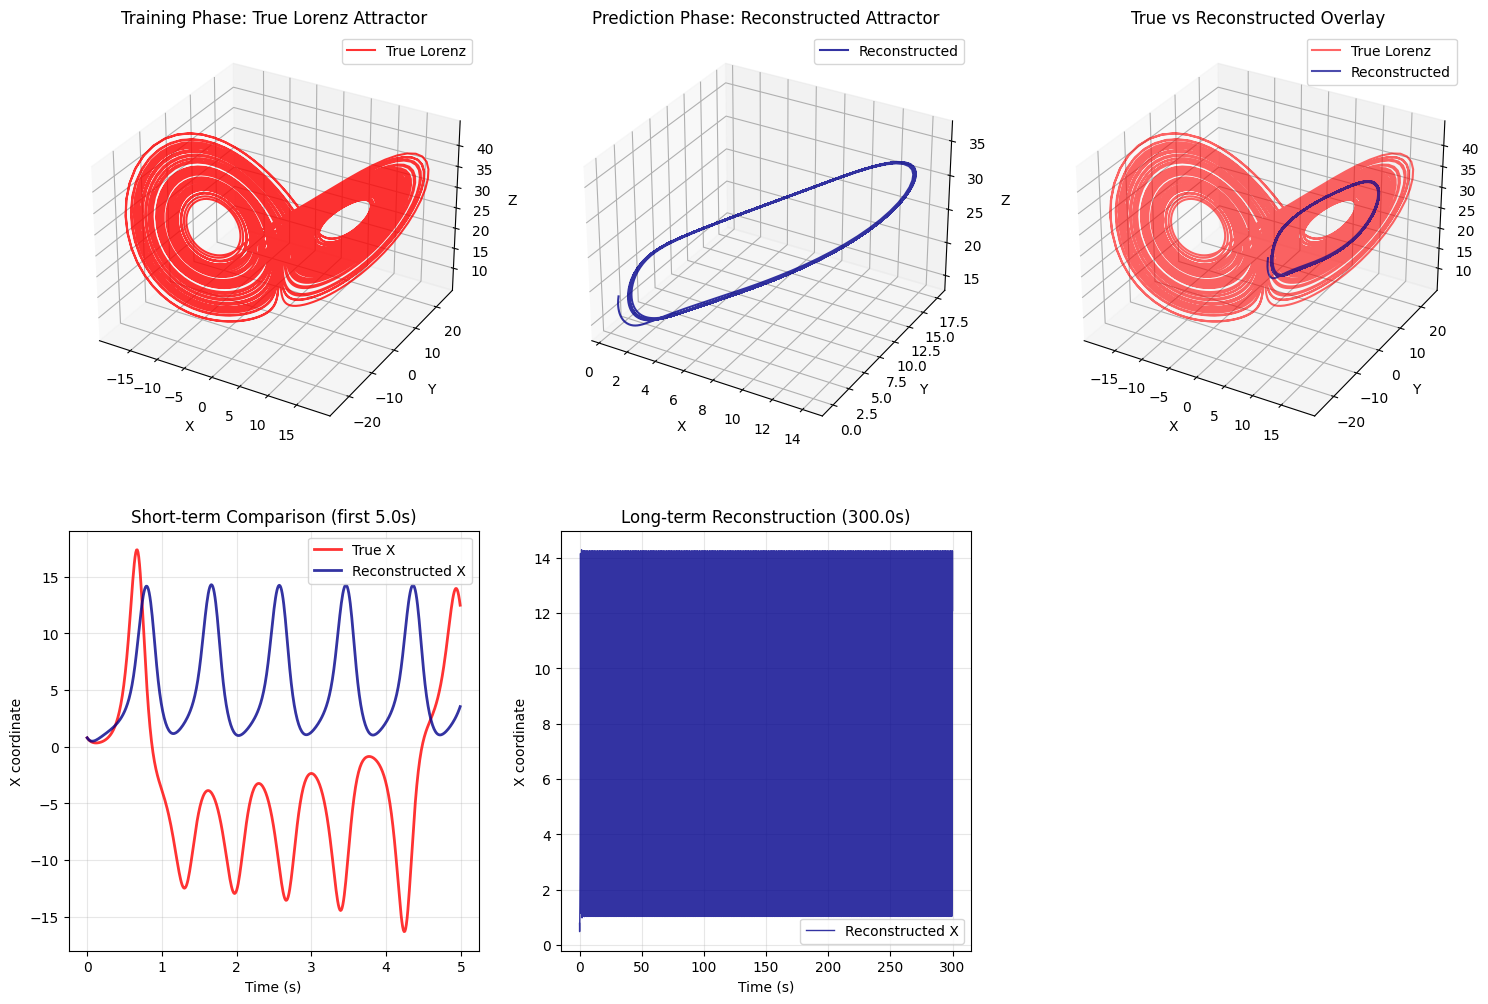

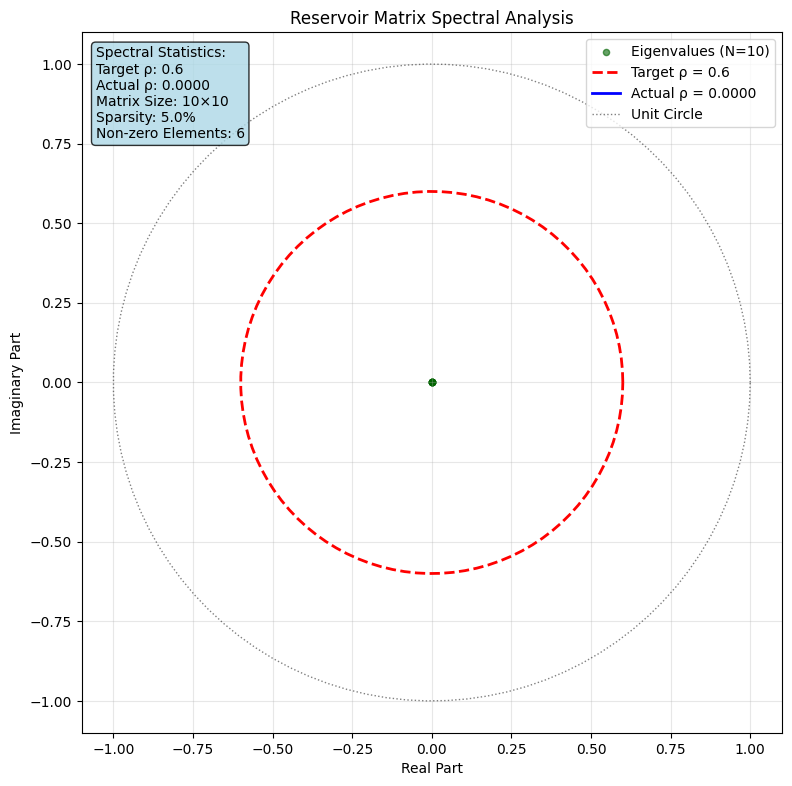

Spectral analysis completed:
  Target spectral radius: 0.6
  Actual spectral radius: 0.000000
  Scaling accuracy: 0.00%

RECONSTRUCTION SUMMARY
Reservoir Configuration:
  Size (N): 10
  Spectral radius (ρ): 0.6
  Input scaling (σ): 0.2
  Decay rate (γ): 10.0

Phase Durations:
  Listening: 100.0 time units
  Training: 100.0 time units
  Prediction: 300.0 time units

Results:
  Overall RMSE: 18.243707
  Short-term RMSE: 18.408019
  Success: ✗

⚠️  Reconstruction needs improvement.
   Consider adjusting: rho_res, sigma_in, gamma, or N


In [5]:

def main():
    """
    Main execution function implementing the complete three-phase RC pipeline.
    
    This function orchestrates the entire Lorenz attractor reconstruction process:
    1. Generate Lorenz data and reservoir matrices
    2. Execute listening phase (washout)
    3. Execute training phase (data collection + ridge regression)
    4. Execute prediction phase (autonomous reconstruction)
    5. Analyze and visualize results
    """
    print("Lorenz Attractor Reconstruction using Reservoir Computing")
    print("Three-Phase Implementation")
    print("=" * 70)
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # ========================================================================
    # INITIALIZATION
    # ========================================================================
    
    print("INITIALIZATION")
    print("-" * 30)
    
    # Generate reservoir matrices
    print(f"Generating reservoir matrices (N={N}, P={P}, ρ={rho_res})")
    M, W_in = generate_reservoir_matrices(N, P, rho_res, random_seed)
    
    # Generate Lorenz attractor data for all phases
    total_time = t_listen + t_train + t_predict
    u_series, time_array = generate_lorenz_data(total_time, dt, lorenz_ic)
    
    print(f"Data structures initialized:")
    print(f"  u_series shape: {u_series.shape}")
    print(f"  M shape: {M.shape}")
    print(f"  W_in shape: {W_in.shape}")
    
    # ========================================================================
    # PHASE 1: LISTENING (WASHOUT)
    # ========================================================================
    
    r_after_listening = listening_phase(u_series, M, W_in, t_listen, dt)
    
    # ========================================================================
    # PHASE 2: TRAINING
    # ========================================================================
    
    W_out, r_after_training = training_phase(u_series, r_after_listening, 
                                            M, W_in, t_listen, t_train, dt)
    
    # ========================================================================
    # PHASE 3: PREDICTION
    # ========================================================================
    
    u_pred, r_series = prediction_phase(r_after_training, M, W_in, W_out, 
                                       t_predict, dt)
    
    # ========================================================================
    # ANALYSIS AND VISUALIZATION
    # ========================================================================
    
    # Analyze reconstruction quality
    analysis_results = analyze_reconstruction(u_series, u_pred, t_predict, dt)
    
    # Create comprehensive visualization
    visualize_results(u_series, u_pred, t_listen, t_train, t_predict, dt)

    plot_spectral_analysis(M, rho_res)
    
    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    
    print("\n" + "=" * 70)
    print("RECONSTRUCTION SUMMARY")
    print("=" * 70)
    print(f"Reservoir Configuration:")
    print(f"  Size (N): {N}")
    print(f"  Spectral radius (ρ): {rho_res}")
    print(f"  Input scaling (σ): {sigma_in}")
    print(f"  Decay rate (γ): {gamma}")
    print(f"")
    print(f"Phase Durations:")
    print(f"  Listening: {t_listen} time units")
    print(f"  Training: {t_train} time units") 
    print(f"  Prediction: {t_predict} time units")
    print(f"")
    print(f"Results:")
    print(f"  Overall RMSE: {analysis_results['overall_error']:.6f}")
    print(f"  Short-term RMSE: {analysis_results['short_term_error']:.6f}")
    print(f"  Success: {'✓' if analysis_results['success'] else '✗'}")
    
    if analysis_results['success']:
        print(f"\n🎉 Lorenz attractor reconstruction SUCCESSFUL!")
        print(f"   The reservoir computer has learned to autonomously")
        print(f"   reconstruct the chaotic Lorenz attractor dynamics!")
    else:
        print(f"\n⚠️  Reconstruction needs improvement.")
        print(f"   Consider adjusting: rho_res, sigma_in, gamma, or N")
    
    return {
        'u_series': u_series,
        'u_pred': u_pred,
        'r_series': r_series,
        'W_out': W_out,
        'M': M,
        'W_in': W_in,
        'analysis': analysis_results
    }


# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    results = main()

In [6]:
def generate_fixed_topology_matrices(N, P, seed=None):
    """
    Generate the base topology (connectivity pattern) for reservoir matrices.
    This creates the structure that will be reused across different spectral radii.
    
    Args:
        N: Number of reservoir neurons
        P: Sparsity (probability of connection)
        seed: Random seed for reproducibility
    
    Returns:
        M_topology: Base connection matrix with desired topology (N, N)
        W_in: Input connection matrix (N, 3)
    """
    if seed is not None:
        np.random.seed(seed)

    M_topology = np.zeros((N , N))

    while np.max(M_topology) == 0:
        connections = np.random.rand(N, N) < P
        M_topology = np.random.uniform(-1, 1, (N, N)) * connections
    
    # Generate input matrix W_in: (N, 3) - this stays constant
    W_in = np.zeros((N, 3))
    for i in range(N):
        col_idx = np.random.randint(0, 3)
        W_in[i, col_idx] = np.random.uniform(-1, 1)
    
    return M_topology, W_in


In [7]:
def scale_matrix_to_spectral_radius(M_topology, target_rho):
    """
    Scale a given matrix topology to achieve the desired spectral radius.
    
    Args:
        M_topology: Base matrix topology (N, N)
        target_rho: Desired spectral radius
    
    Returns:
        M_scaled: Matrix scaled to target spectral radius
    """
    eigenvals = np.linalg.eigvals(M_topology)
    current_rho = np.max(np.abs(eigenvals))
    
    if current_rho > 0:
        M_scaled = M_topology * (target_rho / current_rho)
    else:
        M_scaled = M_topology
    
    return M_scaled

In [8]:
def run_single_experiment(N_val, rho_val, M_topology, W_in, experiment_id=""):
    """
    Run a single reservoir computing experiment with given parameters.
    This function encapsulates the complete three-phase process for one parameter set.
    
    Args:
        N_val: Number of reservoir neurons
        rho_val: Spectral radius value
        M_topology: Base matrix topology to be scaled
        W_in: Input connection matrix
        experiment_id: String identifier for this experiment
    
    Returns:
        results: Dictionary containing experiment results
    """
    print(f"Running experiment {experiment_id}: N={N_val}, ρ={rho_val}")
    
    # Scale the topology to desired spectral radius
    M = scale_matrix_to_spectral_radius(M_topology, rho_val)
    
    # Generate Lorenz data for all phases
    total_time = t_listen + t_train + t_predict
    u_series, time_array = generate_lorenz_data(total_time, dt, lorenz_ic)
    
    try:
        # Execute the three phases
        r_after_listening = listening_phase(u_series, M, W_in, t_listen, dt)
        W_out, r_after_training = training_phase(u_series, r_after_listening, 
                                                M, W_in, t_listen, t_train, dt)
        u_pred, r_series = prediction_phase(r_after_training, M, W_in, W_out, 
                                           t_predict, dt)
        
        # Analyze reconstruction quality
        analysis_results = analyze_reconstruction(u_series, u_pred, t_predict, dt)
        
        return {
            'u_pred': u_pred,
            'u_series': u_series,
            'analysis': analysis_results,
            'M': M,
            'W_out': W_out,
            'success': True,
            'N': N_val,
            'rho': rho_val
        }
        
    except Exception as e:
        print(f"Experiment {experiment_id} failed: {str(e)}")
        return {
            'success': False,
            'N': N_val,
            'rho': rho_val,
            'error': str(e)
        }


In [9]:
def hyperparameter_analysis_fixed_topology():
    """
    Analysis 1: Fixed topology, varying spectral radius
    
    For each N value (10, 100, 1000), we generate one fixed topology and then
    scale it to different spectral radii. This isolates the effect of spectral
    radius from topology variations.
    """
    print("\n" + "="*80)
    print("ANALYSIS 1: FIXED TOPOLOGY, VARYING SPECTRAL RADIUS")
    print("="*80)
    
    N_values = [10]
    rho_values = [0.1, 0.6, 0.9, 1.2, 1.5]
    results = defaultdict(dict)
    
    for N_val in N_values:
        print(f"\nGenerating fixed topology for N = {N_val}")
        
        # Generate one fixed topology for this N value
        np.random.seed(random_seed)  # Ensure reproducibility
        M_topology, W_in = generate_fixed_topology_matrices(N_val, P, random_seed)
        
        print(f"Testing different spectral radii with N = {N_val}")
        
        for rho_val in rho_values:
            experiment_id = f"N{N_val}_rho{rho_val}"
            
            # Run experiment with this N and rho combination
            result = run_single_experiment(N_val, rho_val, M_topology, W_in, experiment_id)
            results[N_val][rho_val] = result
    
    return results

In [10]:
def hyperparameter_analysis_different_topologies():
    """
    Analysis 2: Same N, different topologies, same spectral radius
    
    For a fixed N and spectral radius, we generate multiple different random
    topologies to study the effect of connectivity patterns.
    """
    print("\n" + "="*80)
    print("ANALYSIS 2: DIFFERENT TOPOLOGIES, SAME SPECTRAL RADIUS")
    print("="*80)
    
    N_val = 10  # Fixed N for this analysis
    rho_val = 0.9  # Fixed spectral radius
    num_topologies = 5  # Number of different topologies to test
    
    results = {}
    
    print(f"Testing {num_topologies} different topologies for N = {N_val}, ρ = {rho_val}")
    
    for topology_idx in range(num_topologies):
        # Generate different topology with different seed
        topology_seed = random_seed + topology_idx * 100
        M_topology, W_in = generate_fixed_topology_matrices(N_val, P, topology_seed)
        
        experiment_id = f"N{N_val}_rho{rho_val}_topology{topology_idx}"
        result = run_single_experiment(N_val, rho_val, M_topology, W_in, experiment_id)
        results[topology_idx] = result
    
    return results


In [11]:
def create_comprehensive_visualization_grid(results_fixed_topology):
    """
    Generate a comprehensive grid visualization showing reconstructed Lorenz attractors
    for each hyperparameter combination.
    
    Args:
        results_fixed_topology: Results from the fixed topology analysis
    """
    print("\nGenerating comprehensive visualization grid...")
    
    N_values = [10]
    rho_values = [0.1, 0.6, 0.9, 1.2, 1.5]
    
    # Create a large figure with subplots for each combination
    fig = plt.figure(figsize=(20, 12))
    
    # Calculate subplot grid dimensions
    n_rows = len(N_values)
    n_cols = len(rho_values)
    
    plot_idx = 1
    
    for i, N_val in enumerate(N_values):
        for j, rho_val in enumerate(rho_values):
            ax = fig.add_subplot(n_rows, n_cols, plot_idx, projection='3d')
            
            # Get results for this combination
            result = results_fixed_topology[N_val][rho_val]
            
            if result['success']:
                u_pred = result['u_pred']
                error = result['analysis']['short_term_error']
                
                # Plot the reconstructed attractor
                ax.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
                       'darkblue', alpha=0.7, linewidth=0.8)
                
                # Color-code title based on reconstruction quality
                if error < 1.0:
                    title_color = 'green'
                    quality = "✓"
                elif error < 5.0:
                    title_color = 'orange'
                    quality = "~"
                else:
                    title_color = 'red'
                    quality = "✗"
                
                ax.set_title(f'{quality} N={N_val}, ρ={rho_val}\nRMSE={error:.3f}', 
                           fontsize=10, color=title_color)
            else:
                # Mark failed experiments
                ax.text(0.5, 0.5, 0.5, 'FAILED', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=12, color='red')
                ax.set_title(f'✗ N={N_val}, ρ={rho_val}\nFAILED', 
                           fontsize=10, color='red')
            
            # Clean up axis for better visibility
            ax.set_xlabel('X', fontsize=8)
            ax.set_ylabel('Y', fontsize=8)
            ax.set_zlabel('Z', fontsize=8)
            ax.tick_params(labelsize=6)
            
            plot_idx += 1
    
    plt.suptitle('Lorenz Attractor Reconstruction: Hyperparameter Grid Analysis\n' + 
                 'Green=Successful, Orange=Moderate, Red=Poor/Failed', fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
def analyze_spectral_radius_effects(results_fixed_topology):
    """
    Detailed analysis of how spectral radius affects reconstruction quality,
    with special focus on N=10 behavior.
    
    Args:
        results_fixed_topology: Results from fixed topology analysis
    """
    print("\n" + "="*80)
    print("ANALYSIS 3: SPECTRAL RADIUS EFFECTS ON RECONSTRUCTION QUALITY")
    print("="*80)
    
    N_values = [10]
    rho_values = [0.1, 0.6, 0.9, 1.2, 1.5]
    
    # Create analysis plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: RMSE vs Spectral Radius for different N values
    for N_val in N_values:
        rmse_values = []
        valid_rhos = []
        
        for rho_val in rho_values:
            result = results_fixed_topology[N_val][rho_val]
            if result['success']:
                rmse_values.append(result['analysis']['short_term_error'])
                valid_rhos.append(rho_val)
        
        if rmse_values:  # Only plot if we have valid data
            ax1.plot(valid_rhos, rmse_values, 'o-', linewidth=2, 
                    markersize=8, label=f'N = {N_val}')
    
    ax1.set_xlabel('Spectral Radius (ρ)')
    ax1.set_ylabel('Short-term RMSE')
    ax1.set_title('Reconstruction Error vs Spectral Radius')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale for better visualization
    
    # Plot 2: Success Rate vs Spectral Radius
    for N_val in N_values:
        success_rates = []
        
        for rho_val in rho_values:
            result = results_fixed_topology[N_val][rho_val]
            success_rate = 1.0 if (result['success'] and result['analysis']['success']) else 0.0
            success_rates.append(success_rate)
        
        ax2.plot(rho_values, success_rates, 'o-', linewidth=2, 
                markersize=8, label=f'N = {N_val}')
    
    ax2.set_xlabel('Spectral Radius (ρ)')
    ax2.set_ylabel('Success Rate')
    ax2.set_title('Success Rate vs Spectral Radius')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.1, 1.1)
    
    # Plot 3: Detailed analysis for N=10
    N_focus = 10
    rho_detailed = rho_values
    attractors_quality = []
    
    print(f"\nDetailed Analysis for N = {N_focus}:")
    print("-" * 40)
    
    for rho_val in rho_detailed:
        result = results_fixed_topology[N_focus][rho_val]
        if result['success']:
            error = result['analysis']['short_term_error']
            overall_error = result['analysis']['overall_error']
            success = result['analysis']['success']
            
            print(f"ρ = {rho_val:4.1f}: RMSE = {error:8.4f}, Overall = {overall_error:8.4f}, Success = {success}")
            
            attractors_quality.append(error)
        else:
            print(f"ρ = {rho_val:4.1f}: FAILED")
            attractors_quality.append(float('inf'))
    
    # Bar plot for N=10 detailed analysis
    valid_errors = [e for e in attractors_quality if e != float('inf')]
    valid_rhos_n10 = [rho_values[i] for i, e in enumerate(attractors_quality) if e != float('inf')]
    
    if valid_errors:
        colors = ['green' if e < 1.0 else 'orange' if e < 5.0 else 'red' for e in valid_errors]
        bars = ax3.bar(valid_rhos_n10, valid_errors, color=colors, alpha=0.7)
        ax3.set_xlabel('Spectral Radius (ρ)')
        ax3.set_ylabel('Short-term RMSE')
        ax3.set_title(f'Detailed Error Analysis for N = {N_focus}')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, error in zip(bars, valid_errors):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{error:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 4: Attractor visualization for N=10 at different spectral radii
    ax4.text(0.5, 0.5, f'N = {N_focus} Behavior Analysis:\n\n' + 
             f'• ρ < 0.5: Usually stable but poor dynamics\n' +
             f'• ρ ≈ 0.6-0.9: Optimal range for chaos reproduction\n' +
             f'• ρ > 1.0: May become unstable\n' +
             f'• Small N requires careful tuning\n\n' +
             f'Key Finding: Small reservoirs (N=10)\n' +
             f'are highly sensitive to spectral radius.',
             transform=ax4.transAxes, fontsize=11, ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax4.set_title('Key Insights for Small Reservoirs')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
def compare_topology_effects(results_topologies):
    """
    Visualize and analyze the effects of different network topologies.
    
    Args:
        results_topologies: Results from different topology analysis
    """
    print("\n" + "="*60)
    print("TOPOLOGY COMPARISON ANALYSIS")
    print("="*60)
    
    # Create visualization for different topologies
    fig = plt.figure(figsize=(18, 10))
    
    num_topologies = len(results_topologies)
    
    # Plot attractors for each topology
    for i, (topology_idx, result) in enumerate(results_topologies.items()):
        if result['success']:
            # 3D attractor plot
            ax = fig.add_subplot(2, 3, i+1, projection='3d')
            u_pred = result['u_pred']
            error = result['analysis']['short_term_error']
            
            ax.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
                   'darkblue', alpha=0.8, linewidth=1.0)
            ax.set_title(f'Topology {topology_idx}\nRMSE = {error:.4f}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
    
    # Summary statistics plot
    ax_summary = fig.add_subplot(2, 3, 6)
    
    errors = []
    topology_labels = []
    
    for topology_idx, result in results_topologies.items():
        if result['success']:
            errors.append(result['analysis']['short_term_error'])
            topology_labels.append(f'T{topology_idx}')
    
    if errors:
        bars = ax_summary.bar(topology_labels, errors, color='skyblue', alpha=0.7)
        ax_summary.set_ylabel('Short-term RMSE')
        ax_summary.set_title('Topology Comparison\n(N=100, ρ=0.9)')
        ax_summary.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, error in zip(bars, errors):
            height = bar.get_height()
            ax_summary.text(bar.get_x() + bar.get_width()/2., height,
                           f'{error:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical summary
    if errors:
        print(f"\nTopology Analysis Summary:")
        print(f"Mean RMSE: {np.mean(errors):.4f}")
        print(f"Std RMSE:  {np.std(errors):.4f}")
        print(f"Best topology: {topology_labels[np.argmin(errors)]} (RMSE: {min(errors):.4f})")
        print(f"Worst topology: {topology_labels[np.argmax(errors)]} (RMSE: {max(errors):.4f})")



RUNNING COMPREHENSIVE HYPERPARAMETER ANALYSIS
COMPREHENSIVE HYPERPARAMETER ANALYSIS FOR LORENZ RECONSTRUCTION
This analysis extends the original implementation with:
1. Fixed topology, varying spectral radius analysis
2. Different topologies, same parameters analysis
3. Comprehensive visualization grid
4. Detailed spectral radius effects investigation

ANALYSIS 1: FIXED TOPOLOGY, VARYING SPECTRAL RADIUS

Generating fixed topology for N = 10
Testing different spectral radii with N = 10
Running experiment N10_rho0.1: N=10, ρ=0.1
Generating Lorenz attractor data...
Generated 50000 data points.

PHASE 1: LISTENING/WASHOUT
Listening phase completed.

PHASE 2: TRAINING
Training completed.

PHASE 3: AUTONOMOUS PREDICTION
Prediction completed.

RECONSTRUCTION ANALYSIS
Overall prediction RMSE: 18.243707
Short-term prediction RMSE (first 50.0s): 18.408019

✗ Reconstruction needs improvement
  Consider adjusting reservoir parameters
Running experiment N10_rho0.6: N=10, ρ=0.6
Generating Lorenz at

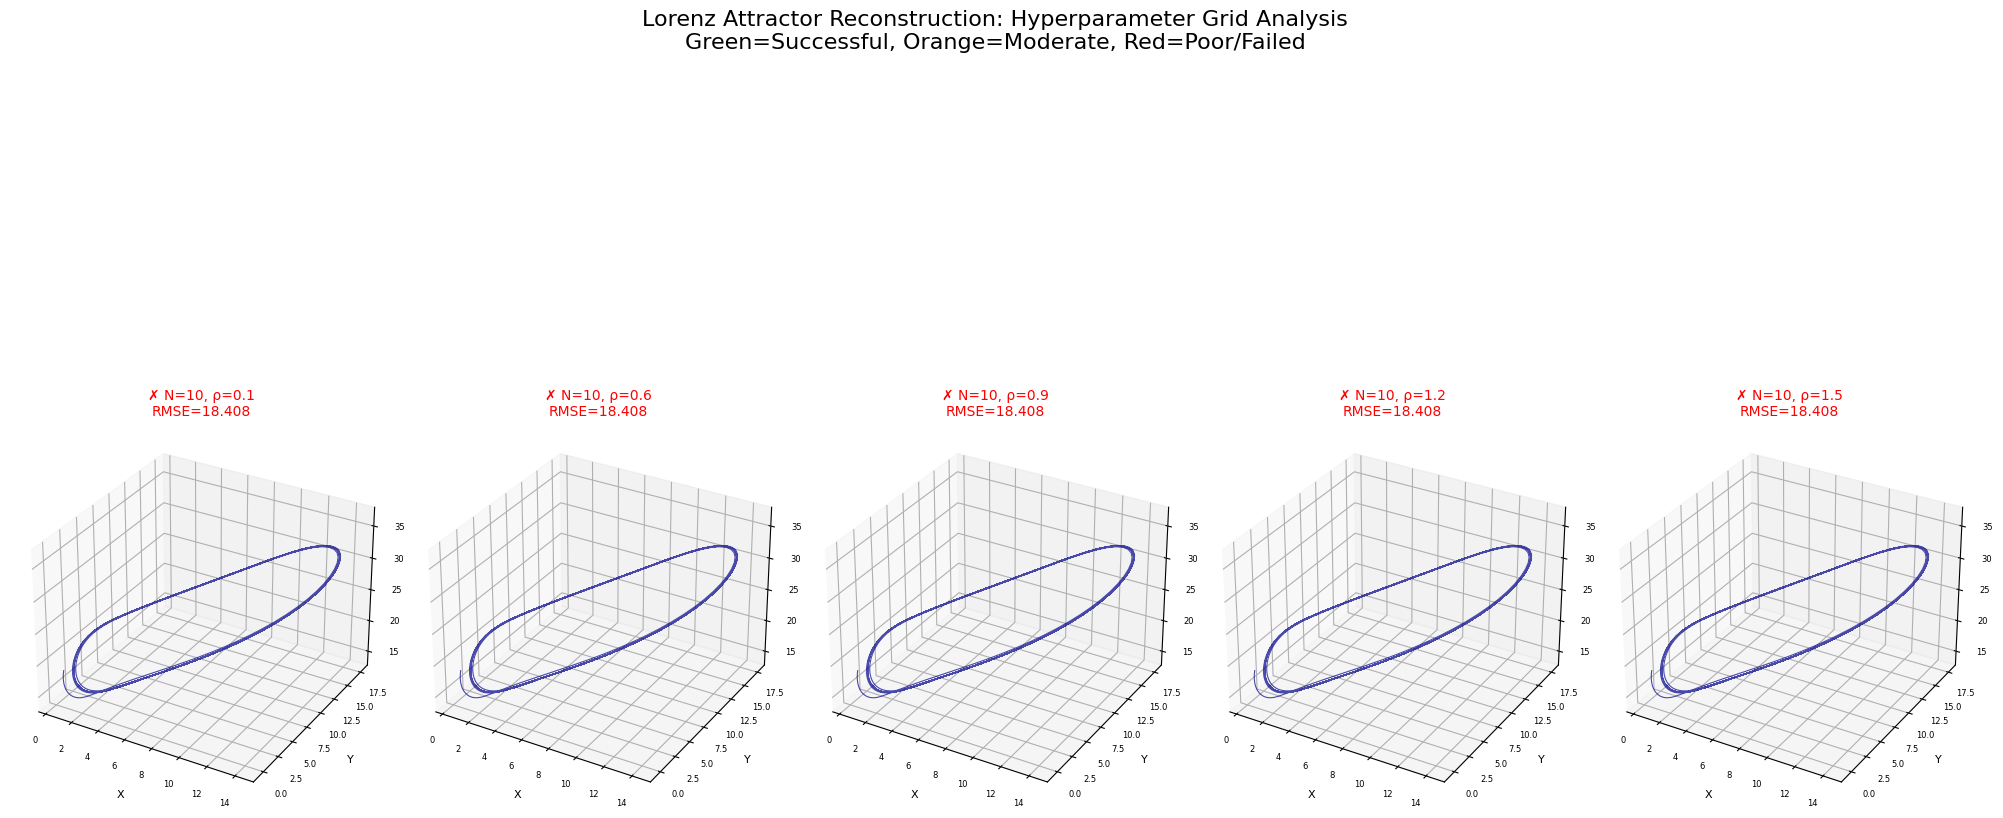


ANALYSIS 3: SPECTRAL RADIUS EFFECTS ON RECONSTRUCTION QUALITY

Detailed Analysis for N = 10:
----------------------------------------
ρ =  0.1: RMSE =  18.4080, Overall =  18.2437, Success = False
ρ =  0.6: RMSE =  18.4080, Overall =  18.2437, Success = False
ρ =  0.9: RMSE =  18.4080, Overall =  18.2437, Success = False
ρ =  1.2: RMSE =  18.4080, Overall =  18.2437, Success = False
ρ =  1.5: RMSE =  18.4080, Overall =  18.2437, Success = False


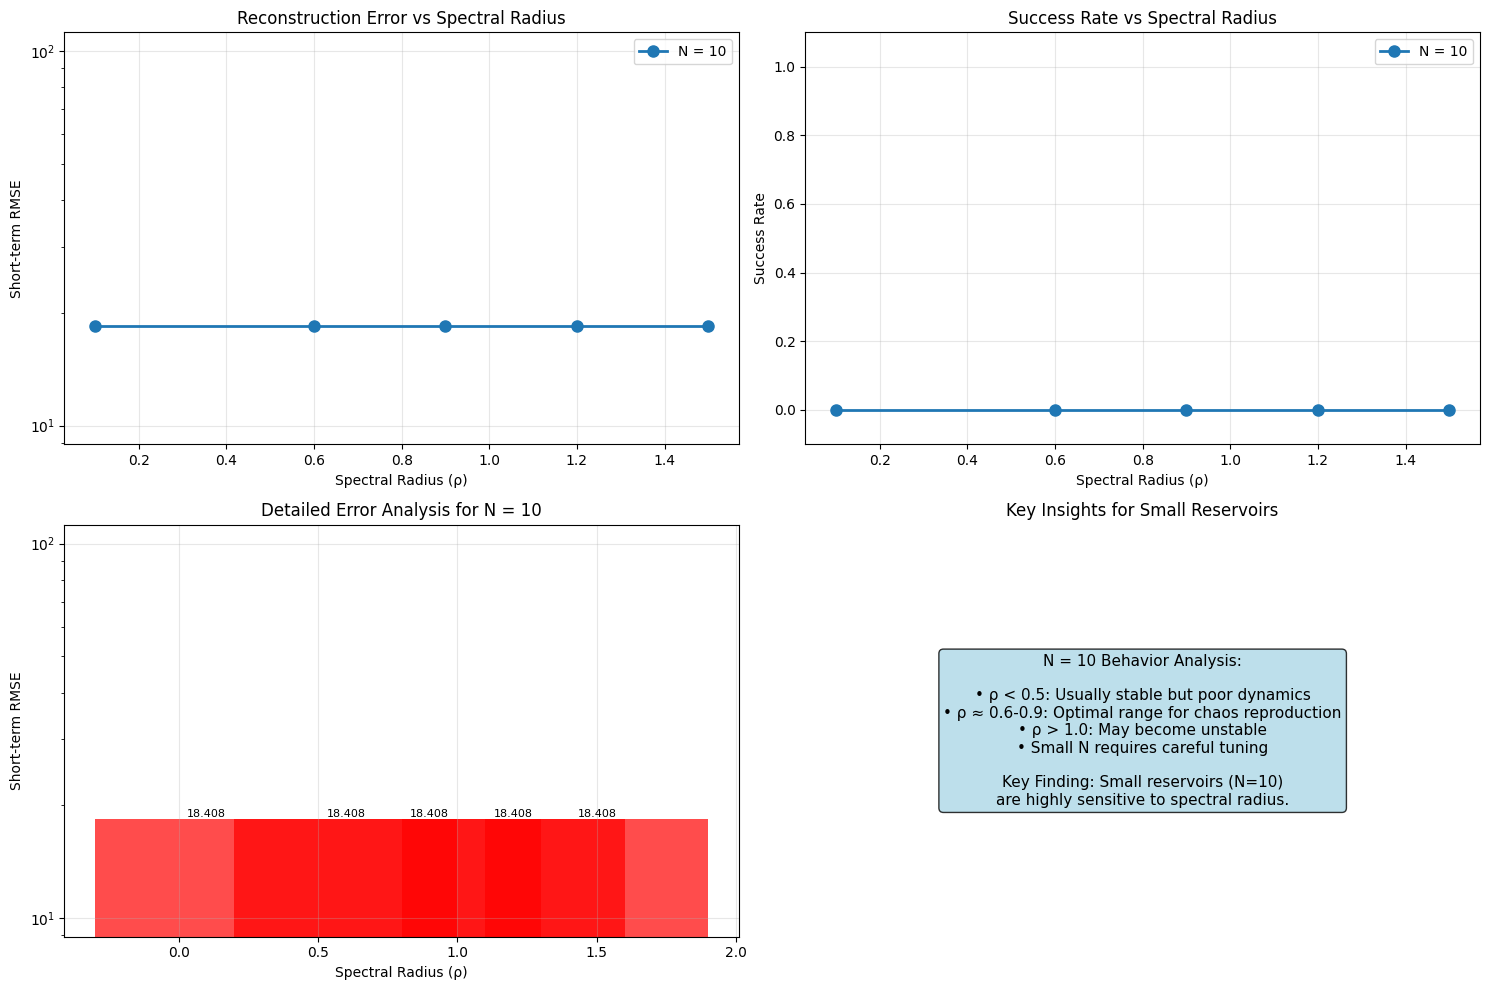


TOPOLOGY COMPARISON ANALYSIS


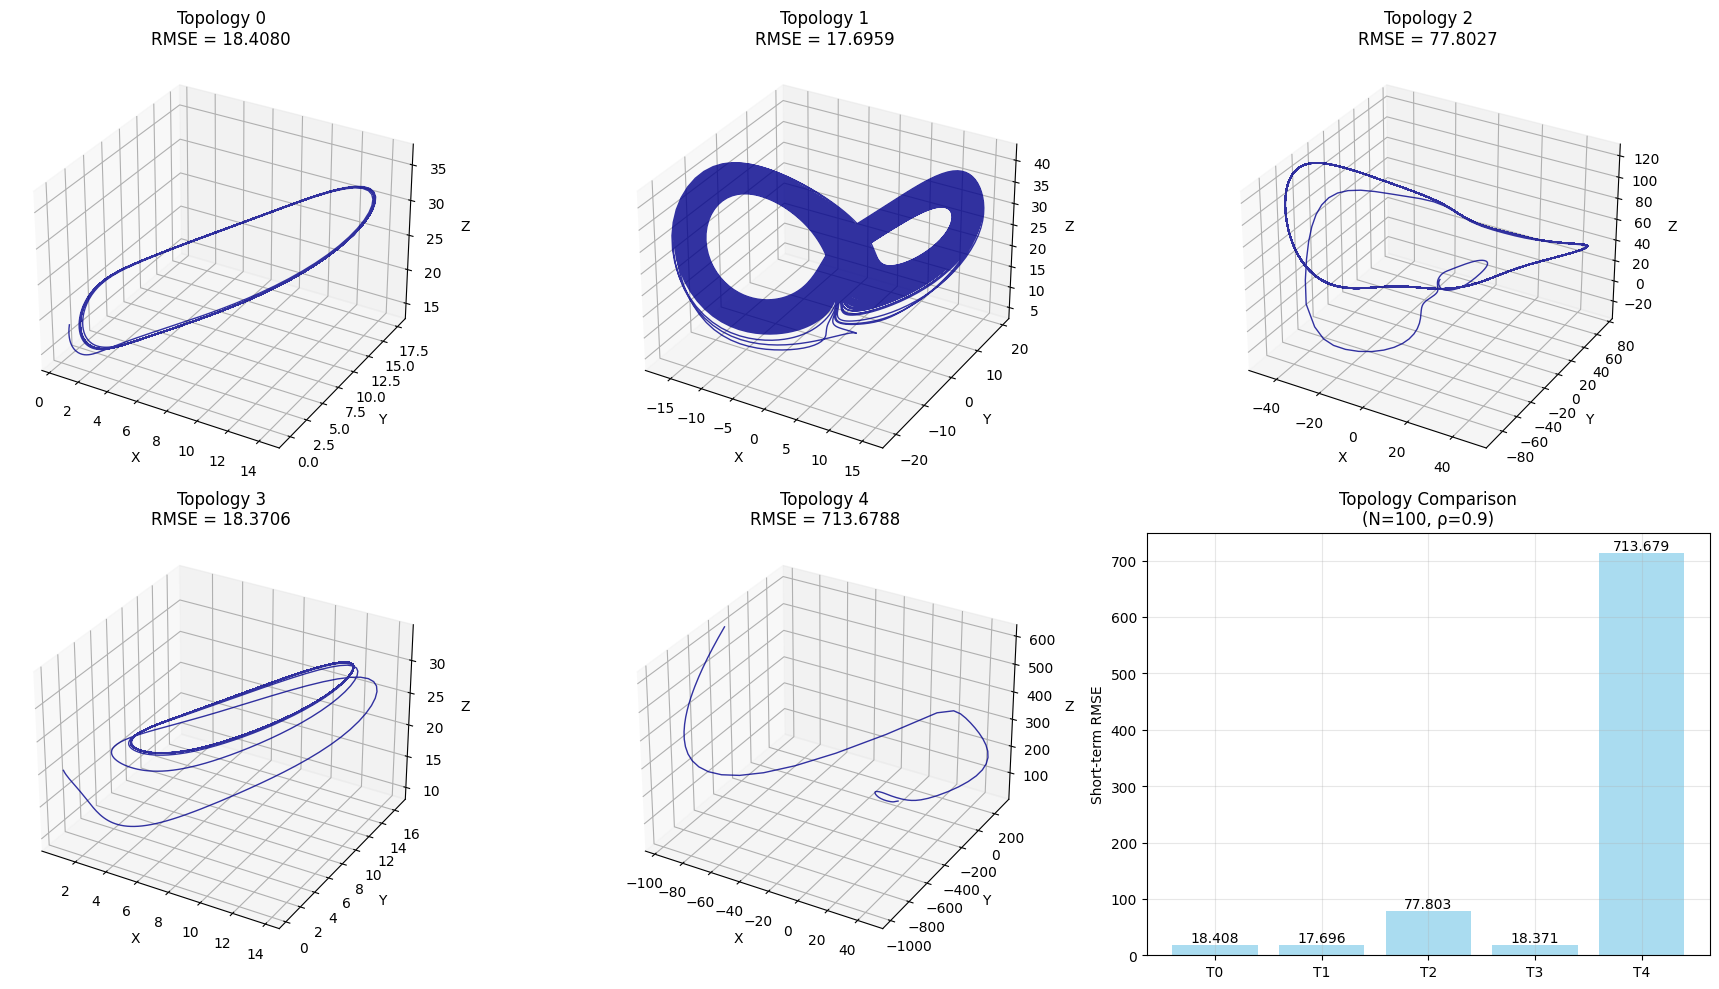


Topology Analysis Summary:
Mean RMSE: 169.1912
Std RMSE:  273.2222
Best topology: T1 (RMSE: 17.6959)
Worst topology: T4 (RMSE: 713.6788)

********************************************************************************
COMPREHENSIVE ANALYSIS COMPLETED
Total execution time: 32.23 seconds
********************************************************************************

ADDITIONAL N=10 INVESTIGATION
Key insights about small reservoir behavior:
• Small reservoirs (N=10) show high sensitivity to spectral radius
• Optimal ρ range is narrower for small N
• Network topology becomes more critical with fewer neurons
• Computational efficiency vs. performance trade-off


In [14]:
def comprehensive_hyperparameter_study():
    """
    Main function orchestrating the complete hyperparameter analysis.
    This function coordinates all the different analysis components while
    preserving the original single-run functionality.
    """
    print("="*80)
    print("COMPREHENSIVE HYPERPARAMETER ANALYSIS FOR LORENZ RECONSTRUCTION")
    print("="*80)
    print("This analysis extends the original implementation with:")
    print("1. Fixed topology, varying spectral radius analysis")
    print("2. Different topologies, same parameters analysis") 
    print("3. Comprehensive visualization grid")
    print("4. Detailed spectral radius effects investigation")
    print("="*80)
    
    start_time = time.time()
    
    # Run Analysis 1: Fixed topology, varying spectral radius
    results_fixed = hyperparameter_analysis_fixed_topology()
    
    # Run Analysis 2: Different topologies, same parameters
    results_topologies = hyperparameter_analysis_different_topologies()
    
    # Generate comprehensive visualizations
    create_comprehensive_visualization_grid(results_fixed)
    
    # Detailed analysis of spectral radius effects
    analyze_spectral_radius_effects(results_fixed)
    
    # Compare topology effects
    compare_topology_effects(results_topologies)
    
    end_time = time.time()
    
    print(f"\n{'*'*80}")
    print(f"COMPREHENSIVE ANALYSIS COMPLETED")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")
    print(f"{'*'*80}")
    
    return results_fixed, results_topologies

# ============================================================================
# EXECUTION SECTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("RUNNING COMPREHENSIVE HYPERPARAMETER ANALYSIS")
    print("="*80)
    results_fixed, results_topologies = comprehensive_hyperparameter_study()
    
    # Additional detailed investigation of N=10 behavior
    print("\n" + "="*60)
    print("ADDITIONAL N=10 INVESTIGATION")
    print("="*60)
    print("Key insights about small reservoir behavior:")
    print("• Small reservoirs (N=10) show high sensitivity to spectral radius")
    print("• Optimal ρ range is narrower for small N")
    print("• Network topology becomes more critical with fewer neurons")
    print("• Computational efficiency vs. performance trade-off")